In [2]:
from dateutil.parser import parse 
import matplotlib as mpl
from matplotlib.pylab import rcParams

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd

# Zählungen Preprocessing

In [49]:
VerkehrsZaehlung = pd.read_csv("https://raw.githubusercontent.com/thereallinusrg/Velo-Zueri-Unfaelle/main/data/2021_verkehrszaehlungen_werte_fussgaenger_velo.csv")

#VeloWege = gpd.read_file(r'data/Velo_wege.gpkg')
#Unfaelle = gpd.read_file(r'data/RoadTrafficAccidentLocations.gpkg')
VerkehrsZaehlung = VerkehrsZaehlung.drop(["FUSS_OUT", "FUSS_IN"], axis = 1)
VerkehrsZaehlung['Sum_Velos'] = VerkehrsZaehlung['VELO_IN'] + VerkehrsZaehlung['VELO_OUT']
VerkehrsZaehlung.head()


,FK_ZAEHLER,FK_STANDORT,DATUM,VELO_IN,VELO_OUT,OST,NORD,Sum_Velos
0,U15G3063865,1357,2021-01-01T00:00,NaN,NaN,2682973,1246329,NaN
1,ECO09113499,3927,2021-01-01T00:00,0.0,3.0,2682873,1245891,3.0
2,U15G3063867,1358,2021-01-01T00:00,NaN,NaN,2683557,1251702,NaN
3,U15G3063869,3011,2021-01-01T00:00,NaN,NaN,2682978,1248744,NaN
4,YSH18065716,3279,2021-01-01T00:00,NaN,NaN,2683437,1247199,NaN


In [46]:
VeloWege = gpd.read_file(r'data/Velo_wege.gpkg')


/opt/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:600: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [47]:
VeloWege.head()

,id1,velo,velostreifen,veloweg,einbahn,fuss,name,map_velo,map_fuss,se_anno_cad_data,objectid,geometry
0,137,0,0,0,0,1,"Bahnhof Oerlikon, Perron Gleis 6",0,0,b'',1.0,"LINESTRING (2683427.088 1251829.395, 2683455.0..."
1,138,0,0,0,0,0,Bahnhofstrasse,0,0,b'',2.0,"LINESTRING (2683164.177 1247919.613, 2683164.9..."
2,139,1,0,0,0,0,Zwischenbächen,1,0,b'',3.0,"LINESTRING (2678697.201 1248708.631, 2678677.6..."
3,140,1,0,0,0,0,Schanzackerstrasse,0,0,b'',4.0,"LINESTRING (2683703.923 1249404.521, 2683724.4..."
4,141,0,0,0,0,1,Rotbuchstrasse Überquerung,0,0,b'',5.0,"LINESTRING (2682958.376 1249518.871, 2682958.2..."


In [50]:
# Filter out Stations that did not count any bicycles

list_stations = VerkehrsZaehlung.FK_STANDORT.unique()
print(VerkehrsZaehlung.shape)

for station in list_stations:
    sum_Zaehlstation = VerkehrsZaehlung.loc[VerkehrsZaehlung["FK_STANDORT"] == station, ["Sum_Velos"]].sum()
    if sum_Zaehlstation[0] == 0:
        VerkehrsZaehlung = VerkehrsZaehlung.drop(VerkehrsZaehlung[VerkehrsZaehlung["FK_STANDORT"] == station].index)
        #VerkehrsZaehlung.drop(index=station, columns='FK_STANDORT')
        
VerkehrsZaehlung.shape


46
(1178570, 8)


(600754, 8)

In [56]:
def resample(df):
  list_stations = df.FK_STANDORT.unique()
  dataframes = []
  for standort in list_stations:
    station = df.loc[df["FK_STANDORT"] == standort]
    station["Date_Hour"] = station["DATUM"].astype(str).str[:13]
    #station = station.set_index(pd.to_datetime(station['DATE_HOUR']))
    grouped = station.groupby("Date_Hour").agg({"FK_STANDORT": min, "VELO_IN": sum, "VELO_OUT": sum, "Sum_Velos": sum, "OST": min, "NORD": min})

    #merged = pd.merge(new, station, on = "DATUM")
    dataframes.append(grouped)
  
  combined = pd.concat(dataframes)

  return combined

Zaehlung_hourly = resample(VerkehrsZaehlung)
Zaehlung_hourly.head()

/var/folders/m7/_3h_ct5n68b9x7svmxnmpq980000gn/T/ipykernel_3783/1346331583.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station["Date_Hour"] = station["DATUM"].astype(str).str[:13]
/var/folders/m7/_3h_ct5n68b9x7svmxnmpq980000gn/T/ipykernel_3783/1346331583.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station["Date_Hour"] = station["DATUM"].astype(str).str[:13]
/var/folders/m7/_3h_ct5n68b9x7svmxnmpq980000gn/T/ipykernel_3783/1346331583.py:6: SettingWithCopyWarning: 
A value is trying to be set on

,FK_STANDORT,VELO_IN,VELO_OUT,Sum_Velos,OST,NORD
Date_Hour,,,,,,
2021-01-01T00,3927,2.0,5.0,7.0,2682873,1245891
2021-01-01T01,3927,3.0,5.0,8.0,2682873,1245891
2021-01-01T02,3927,4.0,1.0,5.0,2682873,1245891
2021-01-01T03,3927,2.0,8.0,10.0,2682873,1245891
2021-01-01T04,3927,3.0,1.0,4.0,2682873,1245891


In [57]:
# Turn it into a GeoDataFrame with point geometries
Zaehlungen = gpd.GeoDataFrame(
    Zaehlung_hourly, geometry=gpd.points_from_xy(Zaehlung_hourly.OST, Zaehlung_hourly.NORD))

<AxesSubplot:>

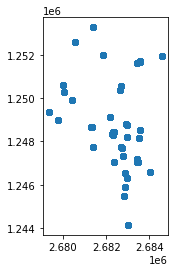

In [17]:
Zaehlungen.plot()

## Normalization

In [18]:
# Export file, so Voronoi_Tesselation can be done in QGIS. There, all accidents 
# are related to the closests Counting Station.
Zaehlungen.to_file('Zaehlungen_test.gpkg', driver='GPKG', layer='Zaehlungen')  


In [53]:
Accidents_Zaehlstation = gpd.read_file("/Users/HF/Library/Mobile Documents/com~apple~CloudDocs/Data Sciene_Grossi Dateie/Accidents_Zaehlstation_GDF.gpkg")
Accidents_Zaehlstation_refined = Accidents_Zaehlstation[["AccidentUID", "AccidentSeverityCategory", "AccidentSeverityCategory_de", "geometry", "FK_STANDORT"]]



/opt/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:600: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

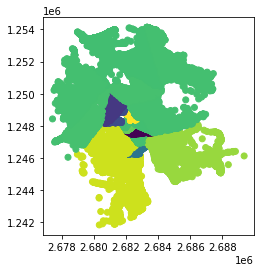

In [54]:
Accidents_Zaehlstation_refined.plot(column='FK_STANDORT', cmap='viridis')

In [58]:
sum_all = Zaehlungen["Sum_Velos"].sum()
print(sum_all)

8000583.0


In [59]:
list_polygons = Zaehlungen.FK_STANDORT.unique()
Zaehlstation_sum = {}
for Zaehlstation in list_polygons:
    sum_Zaehlstation = Zaehlungen.loc[Zaehlungen["FK_STANDORT"] == Zaehlstation, ["Sum_Velos"]].sum()
    Zaehlstation_sum[Zaehlstation] = sum_Zaehlstation / sum_all



In [61]:
Accidents_Zaehlstation_refined.head()

,AccidentUID,AccidentSeverityCategory,AccidentSeverityCategory_de,geometry,FK_STANDORT
0,67477AA5F6FD0150E0530A83942738F2,as4,Unfall mit Sachschaden,POINT (2680349.000 1241844.000),3927.0
1,B912F88A7E7801F4E0430A83942701F4,as4,Unfall mit Sachschaden,POINT (2680551.000 1241911.000),3927.0
2,0BF777D8279E0094E0530A8394274FF8,as4,Unfall mit Sachschaden,POINT (2680598.000 1242101.000),3927.0
3,1799AF1F0C04010CE0530A8394277DC6,as4,Unfall mit Sachschaden,POINT (2680786.000 1242093.000),3927.0
4,E8C4E50BC72A0102E0430A839427DC23,as4,Unfall mit Sachschaden,POINT (2680980.000 1242076.000),3927.0


In [62]:
Accidents_Zaehlstation_refined["Weight"] = ""
for Zaehlstation in list_polygons:
    Accidents_Zaehlstation_refined.loc[(Accidents_Zaehlstation_refined["FK_STANDORT"] == Zaehlstation),'Weight'] = Zaehlstation_sum[Zaehlstation][0]
    print(Zaehlstation_sum[Zaehlstation][0])

0.06783668140184285
0.01765333851295587
0.04209480734091503
0.035434667698591465
0.05638914064137576
0.02510679534228943
0.0739289874250414
0.01562648621981673
0.027373255174029193
0.04651573516579979
0.02614321981285614
0.02597873179992008
0.03264124626917814
0.1697910014807671
0.00489189350326095
0.0006103305221631973
0.08829194072481968
0.0476948992342183
0.11632477283217986
0.054175676947542446
0.012889685664157224
0.012606706286279388


/opt/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [64]:
Accidents_Zaehlstation_refined.head()

,AccidentUID,AccidentSeverityCategory,AccidentSeverityCategory_de,geometry,FK_STANDORT,Weight
0,67477AA5F6FD0150E0530A83942738F2,as4,Unfall mit Sachschaden,POINT (2680349.000 1241844.000),3927.0,0.067837
1,B912F88A7E7801F4E0430A83942701F4,as4,Unfall mit Sachschaden,POINT (2680551.000 1241911.000),3927.0,0.067837
2,0BF777D8279E0094E0530A8394274FF8,as4,Unfall mit Sachschaden,POINT (2680598.000 1242101.000),3927.0,0.067837
3,1799AF1F0C04010CE0530A8394277DC6,as4,Unfall mit Sachschaden,POINT (2680786.000 1242093.000),3927.0,0.067837
4,E8C4E50BC72A0102E0430A839427DC23,as4,Unfall mit Sachschaden,POINT (2680980.000 1242076.000),3927.0,0.067837


In [ ]:
# Write File so Weights can be applied on the Bicycle Lanes in QGIS.
Accidents_Zaehlstation_refined.to_file('Accidents_Zaehlstation_refined_Final.gpkg', driver='GPKG', layer='Accidents_Zaehlstation_refined')  
